# Summarize USGS Water Use Statistics by County

### Water Systems Analysis Group at the University of New Hampshire

    Copyright 2021, University of New Hampshire
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

The United States Geological Survey (USGS) publishes water use statistics every five years for each county in the United States and territories.  The data are provided in a variety of formats (tab delimited text, excel spreadsheets) with corresponding metadata provided in accompanying tables or hosted as HTML on their websites.  Making estimates of how water-use is changing within the United States is complicated for a number of reasons.

1. The definitions of water-use categories and record-keeping has changed over-time.
2. The water use statistics themselves are accumulated through agencies and institutions and may exhibit spatial variability resulting purely from differences in reporting practices and procedures.
3. The variety of formats, and field names make introspection challenging.

This notebook attempts to reduce the burden from the third challenge, with a specific set of documented assumptions to address the first challenge in order to create a continuous record of water use records.  It collates county level data from 1985 through 2015 (and plans to be updated if necessary with future data releases).  The final summary of data is saved to disk as a comma-seperated-values (csv) file easily readable via a number of utilities.  An example is provided to read the resulting table with Pandas (Python).  Furthermore, derived fields are calculated.  Optional cells near the end of the notebook compile statistics into a GeoJSON file using the fiona library (if available),and display an example field using Shapely and Cartopy libraries.

Notes: 

> Does not include statewide data available prior to 1985. 

> The utility does not supply the underlying data, nor does it provide (at this time) automatic fetching of the data.  It is considered the user's responsibility to retrieve the datasets (whole datasets, not individual states) and place them in a single folder. 

The variable `data_source_folder` (aka `fldr`) must be a string to be entered by the user that tells the utility where to find these data.

Sources:

https://water.usgs.gov/watuse/data/
USGS data is in the Public Domain.

The author provides no warranty regarding the veracity of the underlying data provided to or summarized by the USGS, and is in no way affiliated with the USGS. 

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict,OrderedDict

In [2]:
# our data source folder is used globally.  
fldr=data_source_folder="/mnt/c/Data/data/USGSUSCO/"
output_file_name=fldr+"USGS_waterUseStatistics_HumanUse_1985_2015.v2.csv"
county_folder="/mnt/c/Data/data/cb_2015_us_county_500k/" # needed if GeoJSON or mapping is implemented
county_fname=county_folder+"cb_2015_us_county_500k.shp"

In [3]:
mgd2kmy = 3.78541178e-6 * 365.256

###  Water-Use categories of interest


**Units**

*Population*

original units = population in thousands persons

output units   = population in persons

*Supply, Delivery, or Use fluxes*

original units = Million gallons per day ($M gal\ d^{-1}$)

output units   = cubic kilometers per year ($km^3 y^{-1}$)

**Comments**

*DomesticTotalUse*

Data for year 2000 is not provided.  We calculate this value by adding the DomesticSelfSupplied usage (provided) plus the product of the PublicSuppliedPopulation (provided) and a per capita PublicSupply rate (estimated).  The per capita PublicSupply rate for 2000 is calculated as the average per capita PublicSupply rate from 1995 and 2005 for each county.

*IndustrialTotalUse*

Commercial use (provided for 1985 though 1995) is included as IndustrialUse to maintain a consistent record, and follows from the high level disaggregation presented by the USGS [in this table](https://www.usgs.gov/mission-areas/water-resources/science/changes-water-use-categories?qt-science_center_objects=0#qt-science_center_objectsI).  However, Commercial use is most likely a combination of domestic and industrial uses, which is evident by discontinuities in Domestic and Industrial uses for individual counties before and after 1995.  An appropriate disaggregation of Commercial use to both Domestic and Industrial uses on a county by county basis is beyond the scope of this work.

Data for years 2000 through 2015 provides only IndustrialSelfSuppliedUse.  To calculate IndustrialTotalUse we add IndustrialSelfSuppliedUse with the difference between PublicSupplyUse and DomesticPublicDeliveries. 

### Build field names
Some fields are not provided by the USGS for given years, but can be back-calculated with other data and the assumptions described above.  

Entries of `ifunc` and `ofunc` tell the program how to calculate these missing fields.

In [4]:
Uses=OrderedDict(Population={2015:'TP-TotPop',2010:'TP-TotPop',2005:'TP-TotPop',2000:'TP-TotPop',1995:'TotalPop',1990:'po-total',1985:'po-total' },
          DomesticSelfSupp={2015: 'DO-WFrTo', 2010: 'DO-WFrTo', 2005: 'DO-WFrTo', 2000:"DO-WFrTo",1995:'DO-WFrTo',1990:'do-sstot',1985:'do-sstot'},
          DomesticSelfPop={2015: 'DO-SSPop', 2010: 'DO-SSPop', 2005: 'DO-SSPop', 2000:"DO-SSPop",1995:'DO-SSPop',1990:'do-sspop',1985:'do-sspop'},
          DomesticTotalUse={2015:'DO-WDelv',2010:'DO-TOTAL',2005:'DO-TOTAL',
                            2000:"ofunc(DomesticTotal_2000)",
                            1995:'DO-WDelv',1990:'do-total',1985:'do-total'},
          DomesticPubDeliv={2015:'DO-PSDel',2010:'DO-PSDel',2005:'DO-PSDel',
                            2000:"ofunc(DomesticPubDeliv_2000)",
                            1995:'DO-PSDel',1990:'do-psdel',1985:'do-psdel'},
          PublicSupplyPop={2015: 'PS-TOPop', 2010: 'PS-TOPop', 2005: 'PS-TOPop', 2000:'PS-TOPop',
                           1995:'PS-TOPop',1990:'ps-popto',1985:'ps-popto'},
          PublicSupplyUse={2015:'PS-Wtotl',2010:'PS-Wtotl',2005:'PS-Wtotl',2000:'PS-WFrTo',
                           1995:'PS-WFrTo',1990:'ps-wtofr',1985:'ps-wtofr'},
          IndustrialSelfSupp={2015: 'IN-WFrTo',2010:'IN-WFrTo',2005:'IN-WFrTo',2000:'IN-WFrTo',
                              1995:'IN-WFrTo',1990:'in-wtofr',1985:'in-wtofr'},
          IndustrialTotalUse={2015:"ofunc(IndustrialTotal)",
                              2010: "ofunc(IndustrialTotal)",
                              2005: "ofunc(IndustrialTotal)",
                              2000: "ofunc(IndustrialTotal_2000)",
                              1995:'ifunc(IN-WDelv,add,CO-WDelv)',1990:'ifunc(in-total,add,co-total)',1985:'ifunc(in-total,add,co-total)'},
          IrrigationTotalUse={2015: 'IR-WFrTo',2010: 'IR-WFrTo', 2005: 'IR-WFrTo',2000:'IT-WFrTo',
                              1995:'IR-WFrTo',1990:'ir-frtot',1985:'ir-frtot'},
          IrrigationSurfaceUse={2015: 'IR-WSWFr', 2010: "IR-WSWFr", 2005:"IR-WSWFr",2000:"IT-WSWFr",1995:"IR-WSWFr",1990:"IR-WSWFr".lower(),1985:"IR-WSWFr".lower()},
          IrrigationGroundWUse={2015: 'IR-WGWFr', 2010: "IR-WGWFr", 2005: "IR-WGWFr",2000:"IT-WGWFr",1995:"IR-WGWFr",1990:"IR-WGWFr".lower(),1985:"IR-WGWFr".lower()},
          LivestockTotalUse={2015: 'LI-WFrTo', 2010: 'LI-WFrTo', 2005: 'LS-WFrTo',2000:'LS-WFrTo',
                             1995:'LS-WFrTo',1990:'ls-total',1985:'ls-total'} )
# Lists of fluxes to convert and output
volUses="DomesticSelfSupp DomesticTotalUse DomesticPubDeliv PublicSupplyUse IndustrialSelfSupp IndustrialTotalUse IrrigationTotalUse LivestockTotalUse IrrigationSurfaceUse IrrigationGroundWUse".split()
popUses="Population DomesticSelfPop PublicSupplyPop".split()

In [5]:
### Selection of functions to parse individual year files in common formats.  Each returns a raw pandas dataframe.

def read_1985_text(year,uses):
    #1985 1990
    cols="scode area".split()+[use[year] for use in uses.values() if "func" not in use[year]]
    """for use in uses.values():
        if 'ifunc' in use[year]:
            for y in use[year].split(','):
                if y is not 'add':
                    cols.append(y)"""
                    
    cols+=[y for use in uses.values() if "ifunc" in use[year] for y in use[year].split('(')[1].split(')')[0].split(',') if y !='add']
    df = pd.read_csv(fldr+"us{}co.txt".format(str(year)[-2:]),sep="\t",\
                          usecols=cols,\
                          dtype={"area":str,"scode":str})
    df["FIPS"]=df['scode']+df['area']
    df["FIPS"]=df["FIPS"].astype(str)    
    return df

def read_1995_text(year,uses):
    #1995
    cols="StateCode CountyCode".split()+[use[year] for use in uses.values() if "func" not in use[year]]
    cols+=[y for use in uses.values() if "ifunc" in use[year] for y in use[year].split('(')[1].split(')')[0].split(',') if y !='add']
    #print pd.read_csv(fldr+"us{}co.txt".format(state,str(year)[-2:]),sep="\t")
    df = pd.read_csv(fldr+"us{}co.txt".format(str(year)[-2:]),sep="\t",\
                          usecols=cols,\
                          dtype={"CountyCode":str,"StateCode":str})
    df["FIPS"]=df['StateCode']+df['CountyCode']
    df["FIPS"]=df["FIPS"].astype(str)
    return df

def read_2000_excel(year,uses):
    # Parses water uses for the 200{0}'s
    #2000 2005
    cols=["FIPS"]+[use[year] for use in uses.values() if "func" not in use[year]]
    #print pd.read_csv(fldr+"us{}co.txt".format(state,str(year)[-2:]),sep="\t")
    df = pd.read_csv(fldr+"usco{}.txt".format(year),sep="\t",\
                          usecols=cols,\
                          dtype={"FIPS":str})
    fipser=lambda x: "0"+x if len(x)== 4 else x
    df["FIPS"]=df["FIPS"].astype(str).apply(fipser)
    return df
    
def read_2010(year,uses):
    #2010
    cols=["FIPS"]+[use[year] for use in uses.values() if "func" not in use[year]]
    #print pd.read_csv(fldr+"us{}co.txt".format(state,str(year)[-2:]),sep="\t")
    df = pd.read_csv(fldr+"usco{}.dat".format(year),sep="\t",\
                          usecols=cols,\
                          dtype={"FIPS":str})
    df["FIPS"]=df["FIPS"].astype(str)
    return df
def read_2015(year,uses):
    #2015
    cols=["FIPS"]+[use[year] for use in uses.values() if "func" not in use[year]]
    #print pd.read_csv(fldr+"us{}co.txt".format(state,str(year)[-2:]),sep="\t")
    df = pd.read_csv(fldr+"usco{}v2.csv".format(year),usecols=cols,\
                          dtype={"FIPS":str},skiprows=1)
    
    fipser=lambda x: "0"+x if len(x)== 4 else x
    df["FIPS"]=df["FIPS"].astype(str).apply(fipser)
    return df

def rdr(year,uses,vol_uses,pop_uses):
    # Processes data for a given year and returns a clean dataframe 
    if (year < 1985) | (year % 5 != 0):
        raise "No water use data for year {}".format(year)
    if (year >= 1985) & (year < 1994):
        df= read_1985_text(year,uses)
    if (year == 1995):
        df= read_1995_text(year,uses)
    if (year in [2000,2005]):
        df= read_2000_excel(year,uses)
    if (year == 2010):
        df=read_2010(year,uses)
    if (year == 2015):
        df= read_2015(year,uses)   
        #1985 1990
    # Conform each returned dataframe to a common format
    renamer=dict([(use[year],key) for key,use in uses.items() if "func" not in use[year]])
    df = df.rename(columns=renamer)
    # Make necessary calculations from multiple data fields when missing
    for name,use in uses.items():
        if 'ifunc' in use[year]:
            (first,func,second)=use[year].split('(')[1].split(')')[0].split(',')
            assert func == 'add',"Inner field calculation calls for unsupported operator"
            df[name]=df[first].add(df[second]) # fortunately all functions are additive
    df["FIPS"]=df['FIPS'].astype(str)
    df.set_index("FIPS",inplace=True)
    # Unit conversions
    df[list( set(df.columns) & set(vol_uses) )] *= mgd2kmy
    df[list( set(df.columns) & set(pop_uses) )] *= 1000 # population
    # Remove unused columns
    addCols=list( set(uses.keys()) - set(df.columns))    
    for col in addCols:
        df[col]=pd.Series(dtype=float)
    for col in df.columns:
        if col.endswith('_A'):
            df[col]=df[col[:-2]+'_B']
    return df.loc[:,uses.keys()]

# Define outer function calculations
def DomPubDeliv2000(df,year=2000):
    # In 2000 We nned to use data from 1995 and 2005 to estimate
    x1=df.loc[(slice(None),year),'PublicSupplyPop']
    x2=df.loc[(slice(None),[1995,2005]),'PublicSupplyUse'].sum(level=0)
    x3=df.loc[(slice(None),[1995,2005]),'PublicSupplyPop'].sum(level=0)
    x=x1*x2/x3
    return x

def apply_ofunc(df,fun_nm,year):
    funcs={'ofunc(DomesticTotal_2000)':df.loc[(slice(None),year),'DomesticSelfSupp']+DomPubDeliv2000(df),
           'ofunc(DomesticPubDeliv_2000)':DomPubDeliv2000(df),
           'ofunc(IndustrialTotal)':(df.loc[(slice(None),year),'PublicSupplyUse']- df.loc[(slice(None),year),'DomesticPubDeliv']).clip(lower=0.0)\
           +df.loc[(slice(None),year),'IndustrialSelfSupp'],
           'ofunc(IndustrialTotal_2000)':(df.loc[(slice(None),year),'PublicSupplyUse']- DomPubDeliv2000(df)).clip(lower=0)+df.loc[(slice(None),year),'IndustrialSelfSupp']}
    return funcs[fun_nm]

def calc_dependencies(df,uses,ys):
    for nm,use in uses.items():
        for y in ys:
            if 'ofunc' in use[y]:
                df.loc[(slice(None),y),nm]=apply_ofunc(df,use[y],y)
    return df

#### Perform aggregation of Water Use Statistics

In [6]:
dfs={}
years=range(1985,2016,5)
for y in years:
    print(y)
    dfs[y]=rdr(y,Uses,volUses,popUses)
df=pd.concat(dfs,names="Year FIPS".split()).swaplevel(0,1).sort_index()
df=df.drop('nan',level=0)
df["Population"]=df["Population"].apply(np.ceil).astype(int)
df=calc_dependencies(df,Uses,years)

1985
1990
1995
2000
2005
2010
2015


### Present summary statistics

In [7]:
print(df.describe())

         Population  DomesticSelfSupp  DomesticSelfPop  DomesticTotalUse  \
count  2.256500e+04      21877.000000     2.186900e+04      21772.000000   
mean   8.798422e+04          0.001505     1.339608e+04          0.012256   
std    2.878891e+05          0.002868     2.516093e+04          0.047704   
min    0.000000e+00          0.000000    -1.073000e+04          0.000000   
25%    1.104100e+04          0.000194     1.720000e+03          0.001341   
50%    2.458000e+04          0.000636     5.813000e+03          0.002959   
75%    6.006000e+04          0.001645     1.520000e+04          0.007522   
max    1.017029e+07          0.104749     1.010120e+06          2.236696   

       DomesticPubDeliv  PublicSupplyPop  PublicSupplyUse  IndustrialSelfSupp  \
count      21866.000000     2.186900e+04     22565.000000        22565.000000   
mean           0.010756     7.424694e+04         0.017391            0.007769   
std            0.046343     2.769585e+05         0.069957            0.0

Notice negative values for DomesticSelfSupplied.  The DomesticSelfSuppliedPopulation variable is calcualted as the Total Population of County  - minus - the population served by public supply.  Below are the counties where the public served population exceeded the population of the whole county, and the total excess population across all records.  The saved dataset forces these populations to zero.

In [8]:
print(df.loc[df["DomesticSelfPop"]<0,"DomesticSelfPop"])
print("Total: ",(-1*df.loc[df['DomesticSelfPop']<0,"DomesticSelfPop"]).sum())

FIPS   Year
27033  2010       -3.0
27081  2010       -4.0
27117  2010       -4.0
27173  2010       -2.0
40063  1995      -10.0
42101  2010       -4.0
51680  2000   -10730.0
72013  2000      -10.0
72041  2000      -10.0
72067  2000      -10.0
72109  2000      -10.0
72153  2000      -10.0
Name: DomesticSelfPop, dtype: float64
Total:  10807.0


In [9]:
df[df<0]=0.0
print(df.describe())
df.to_csv(output_file_name)

         Population  DomesticSelfSupp  DomesticSelfPop  DomesticTotalUse  \
count  2.256500e+04      21877.000000     2.186900e+04      21772.000000   
mean   8.798422e+04          0.001505     1.339657e+04          0.012256   
std    2.878891e+05          0.002868     2.516057e+04          0.047704   
min    0.000000e+00          0.000000     0.000000e+00          0.000000   
25%    1.104100e+04          0.000194     1.720000e+03          0.001341   
50%    2.458000e+04          0.000636     5.813000e+03          0.002959   
75%    6.006000e+04          0.001645     1.520000e+04          0.007522   
max    1.017029e+07          0.104749     1.010120e+06          2.236696   

       DomesticPubDeliv  PublicSupplyPop  PublicSupplyUse  IndustrialSelfSupp  \
count      21866.000000     2.186900e+04     22565.000000        22565.000000   
mean           0.010756     7.424694e+04         0.017391            0.007769   
std            0.046343     2.769585e+05         0.069957            0.0

#### Example of reading resulting summary table

In [10]:
df=pd.read_csv(output_file_name,dtype={'FIPS':str},index_col="Year") 
# Pandas will force recognition of FIPS as int() if asked to create multi-index from read_csv, so ...
df.set_index('FIPS',append=True,inplace=True)
df=df.reorder_levels((1,0))
print(df.describe())
print(df.index)

         Population  DomesticSelfSupp  DomesticSelfPop  DomesticTotalUse  \
count  2.256500e+04      21877.000000     2.186900e+04      21772.000000   
mean   8.798422e+04          0.001505     1.339657e+04          0.012256   
std    2.878891e+05          0.002868     2.516057e+04          0.047704   
min    0.000000e+00          0.000000     0.000000e+00          0.000000   
25%    1.104100e+04          0.000194     1.720000e+03          0.001341   
50%    2.458000e+04          0.000636     5.813000e+03          0.002959   
75%    6.006000e+04          0.001645     1.520000e+04          0.007522   
max    1.017029e+07          0.104749     1.010120e+06          2.236696   

       DomesticPubDeliv  PublicSupplyPop  PublicSupplyUse  IndustrialSelfSupp  \
count      21866.000000     2.186900e+04     22565.000000        22565.000000   
mean           0.010756     7.424694e+04         0.017391            0.007769   
std            0.046343     2.769585e+05         0.069957            0.0

### Calculate derived quantities of interest

In [11]:
df["UrbanUse"]=df["DomesticTotalUse"]+df["IndustrialTotalUse"] # km3/year
df["AgUse"]=df["IrrigationTotalUse"]+df["LivestockTotalUse"] # km3/year
df["Domest_cap"]=1e9*df["DomesticTotalUse"]/365.256/df["Population"] # m3/day
df["Indust_cap"]=1e9*df["IndustrialTotalUse"]/365.256/df["Population"] # m3/day
df["SW_ratio"]=df["IrrigationSurfaceUse"] / df["IrrigationTotalUse"] # ratio
print( df.columns)

Index(['Population', 'DomesticSelfSupp', 'DomesticSelfPop', 'DomesticTotalUse',
       'DomesticPubDeliv', 'PublicSupplyPop', 'PublicSupplyUse',
       'IndustrialSelfSupp', 'IndustrialTotalUse', 'IrrigationTotalUse',
       'IrrigationSurfaceUse', 'IrrigationGroundWUse', 'LivestockTotalUse',
       'UrbanUse', 'AgUse', 'Domest_cap', 'Indust_cap', 'SW_ratio'],
      dtype='object')


##  Create  GeoJSON

If fiona is not installed (which requires install of OGR from OSGEO) the remainder of this notebook is not for you.

In [12]:
import os
import fiona

In [13]:
def create_data_json( df, year ):
    lyr_name="usgs_county_water_{}".format(year)
    out_name=fldr+lyr_name+".json"
    if os.path.exists(out_name):
        # If you want the file re-written, mv it.
        return
    with fiona.open(county_fname,'r') as inShapefile:
        source_crs=inShapefile.crs
        schema=inShapefile.schema
        schema["geometry"]="MultiPolygon"
        new_attrs=OrderedDict([(x,"float") for x in df.columns])
        schema["properties"].update(new_attrs)
        out_driver='GeoJSON'
        with fiona.open(out_name,'w',driver=out_driver,crs=source_crs,schema=schema) as outData:
            new_records=[]
            for record in inShapefile.values():
                try:
                    for col in df.columns:
                        record["properties"][col]=df.loc[(record["properties"]["GEOID"],year),col]
                    if record["geometry"]["type"] == "Polygon":
                        record["geometry"]["type"] = "MultiPolygon"
                        record["geometry"]["coordinates"]=[record["geometry"]["coordinates"]]
                    new_records.append(record)
                except KeyError:
                    print(record["properties"]["GEOID"]," not in USGS statistics.")
                    continue
            outData.writerecords(new_records)

In [14]:
for year in range(1985,2016,5):
    create_data_json(df,year)

### Plot example data

Plot the fraction of irrigation water derived from surface water sources (as opposed to groundwater) for CONUS.

The fraction of surface water used for irrigation can be quite variable through time for each county.  For instance the difference between the ratio for each county can be $\pm$100%, and has a fairly high standard deviation (see below).

In [15]:
print(df["SW_ratio"].groupby(level=1).diff(1).describe()) # 
print(df["SW_ratio"].groupby(level=1).diff(1).std(level=0).describe())

count    17723.000000
mean         0.000202
std          0.441333
min         -1.000000
25%         -0.186488
50%          0.000000
75%          0.189979
max          1.000000
Name: SW_ratio, dtype: float64
count    2897.000000
mean        0.202664
std         0.170059
min         0.000000
25%         0.068402
50%         0.166760
75%         0.303292
max         1.272792
Name: SW_ratio, dtype: float64


While a reasonable hypothesis is that this temporal variability can be explained by drought conditions (irrigators switch to greater groundwater withdrawals when surface water is unavailable), we do not test this, but instead assume that over the climatological record between 1985 and 2015, the mean ratio of surface to total irrigation water may be a more appropriate representation of typical county-wide irrigation water sourcing. 

In [16]:
sw_ratio = df["SW_ratio"].mean(level=0)

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import shapely.geometry as geometry
# Please note: shapely must be installed from source and proper integration with GEOS ensured.
#              see https://pypi.org/project/Shapely/
%matplotlib inline

In [18]:
year = 2015
county_geoids = [(geometry.MultiPolygon(geometry.shape(pol['geometry'])),pol['properties']['GEOID']) for pol in fiona.open(fldr+"usgs_county_water_{}.json".format(year))]

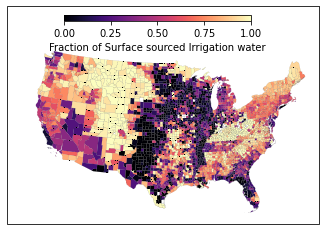

In [19]:
cmap=plt.get_cmap('magma')
fig = plt.figure(figsize=(6.5,4))
globe = cartopy.crs.Globe(semimajor_axis=6371000.)
proj = cartopy.crs.LambertConformal(standard_parallels=[25.0], globe=globe)

ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent((-125., -70., 21., 54.))  # Conterminous USA
year = 2015

for county_geoid in county_geoids:
    color = cmap(sw_ratio.loc[county_geoid[1]])
    ax.add_geometries(county_geoid[0],cartopy.crs.PlateCarree(),facecolor=color,edgecolor='k',linewidth=0.05)
cax = fig.add_axes([0.3, 0.83, 0.4, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Fraction of Surface sourced Irrigation water', fontsize=10)
cb.set_ticks(np.arange(0, 1.01, 0.25))